# CSC420 Assignment 4 Implementation Task

In [1]:
import matplotlib.pyplot as plt
import scipy
import cv2
import numpy as np
import math
from scipy.special import softmax
from mpldatacursor import datacursor

In [2]:
def get_image(path, coloring=cv2.IMREAD_GRAYSCALE):
    raw_image = cv2.imread(path)
    rgb_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

    # For resize
    scale_percent = 200 # percent of original size
    width = int(raw_image.shape[1] * scale_percent / 100)
    height = int(raw_image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_image = cv2.resize(raw_image, dim, interpolation = None)

    grey_image = cv2.imread(path, coloring)
    # plt.imshow(raw_image, vmin=0, vmax=255)
    # plt.imshow
    return rgb_image, grey_image, resized_image

In [3]:
def label_points(image, points):
    plt.imshow(image, cmap='gray')
    plt.scatter(points[1], points[0], s=5, color='blue')
    plt.show()
    return None

In [4]:
def label_est_homography(image, points1, points2):
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1),plt.imshow(image, cmap='gray'), plt.scatter(points1[1], points1[0], marker='s', s=15, color='red')
    plt.subplot(1,2,2), plt.imshow(image, cmap='gray'), plt.scatter(points2[1], points2[0], marker='s', s=15, color='green')
    plt.show()
    return None

In [5]:
def find_matrix(pairs=5, p1=None, p2=None):
    print(pairs)
    A = np.zeros(shape=(2 * pairs, 9), dtype=float)
    for i in range(pairs):
        # For odd rows 
        odd =2*i
        A[odd][0], A[odd][1] = p1[0][i], p1[1][i] # x_1, y_1
        A[odd][2] = 1 # 1
        A[odd][6] = - p2[0][i] *  p1[0][i] # - x_1' * x_1
        A[odd][7] = -  p2[0][i] * p1[1][i] # - x_1' * y_1
        A[odd][8] = -  p2[0][i] # - x_1'

        # For even rows 
        even = odd + 1
        A[even][3], A[even][4] = p1[0][i], p1[1][i] # x_1, y_1
        A[even][5] = 1 # 1
        A[even][6] = - p2[1][i] *  p1[0][i] # - y_1' * x_1
        A[even][7] = -  p2[1][i] * p1[1][i] # - y_1' * y_1
        A[even][8] = -  p2[1][i] # - y_1'
    return A

In [6]:
def compute_homography(A):
    B = np.matmul(A.T, A)
    eig_val, eig_vec = np.linalg.eig(B)
    print(B.shape)
    min_index = np.where(eig_val == np.min(eig_val))[0]
    h = eig_vec[:, min_index]
    mat = h.reshape(3, 3)
    return mat

In [7]:
def compute_transformation(no_pairs, M, source, actual): 
    estimated = []
    for i in range(no_pairs):
        src = np.array( [source[0][i], source[1][i], 1])
        est = np.matmul(M, src)
        est /= est[2]
        estimated.append(est[:2])
    estimated = np.array(estimated).transpose(1,0)
    return estimated, actual

In [8]:
def compute_transformation_pixel(M, v):
    vec = np.array([v[0], v[1], 1])
    rslt = np.dot(M, vec)
    rslt /= rslt[2]
    return np.round(rslt[:2])

In [9]:
def superesolution(raw_image, raw_image_bar, matrix):
    margin = 150
    height = raw_image.shape[0] + 2 * margin
    width = raw_image.shape[1] + 2 * margin
    new_image = np.zeros(shape=(height, width, 3), dtype=int)
    for i in range(new_image.shape[0]):
        for j in range(new_image.shape[1]):
            if new_image.shape[0] - 150 > i > 149 and new_image.shape[1] - 150 > j > 149:
                new_image[i][j][0] = raw_image[i-150][j-150]
            new_coord = compute_transformation_pixel(matrix, [i-149, j-149]).astype(int)
            x, y = new_coord[0], new_coord[1]
            if 0 <= y < 1504 and 0 <= x < 1000:
                new_image[i][j][1] = raw_image_bar[x][y]
                new_image[i][j][2] = raw_image_bar[x][y]
    return new_image

(<AxesSubplot: >, <matplotlib.image.AxesImage at 0x27d25ef17c0>)

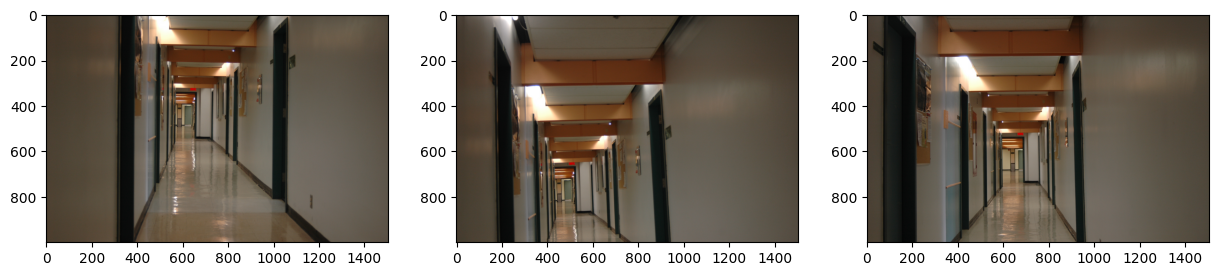

In [10]:
hallway_1, hallway_1_grey, hallway_1_resized = get_image('hallway_images/hallway1.jpg')
hallway_2, hallway_2_grey, hallway_2_resized = get_image('hallway_images/hallway2.jpg')
hallway_3, hallway_3_grey, hallway_3_resized = get_image('hallway_images/hallway3.jpg')
plt.figure(figsize=(15,15))
plt.subplot(1,3,1), plt.imshow(hallway_1)
plt.subplot(1,3,2), plt.imshow(hallway_2)
plt.subplot(1,3,3), plt.imshow(hallway_3)

In [11]:
# Hyperparameters
no_pairs = 6

## CASE I (right wall 1 ~ 2)

[292 445 227 447 266 180]
[ 774  790  847  883  950 1094]


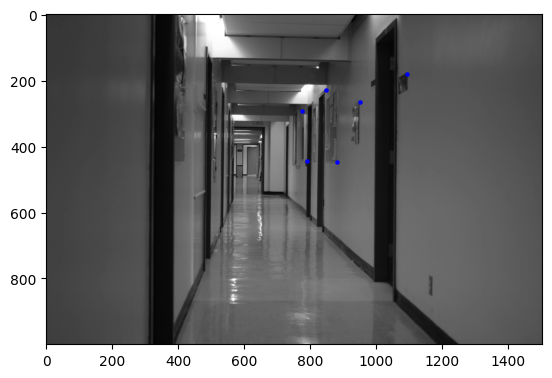

In [12]:
# Height, width
p11 = [292, 774]
p12 = [445, 790]
p13 = [227, 847]
p14 = [447, 883]
p15 = [266, 950]
p16 = [180, 1094]

points_1_1 = [p11, p12, p13, p14, p15, p16]
points_1_1 = np.array(points_1_1)
points_1_1= points_1_1.transpose((1, 0))
print(points_1_1[0])
print(points_1_1[1])
label_points(hallway_1_grey, points_1_1)

[615 765 550 764 580 488]
[636 658 703 748 806 944]


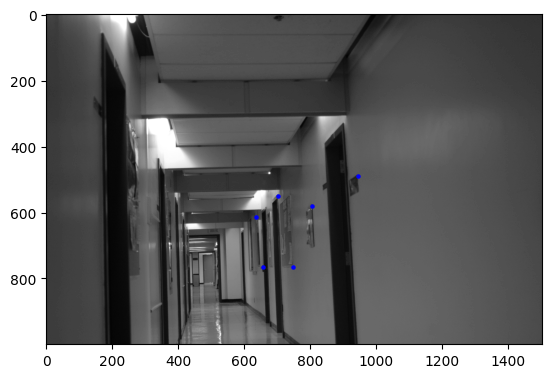

In [13]:
p21 = [615, 636]
p22 = [765, 658]
p23 = [550, 703]
p24 = [764, 748]
p25 = [580, 806]
p26 = [488, 944]

points_1_2 = [p21, p22, p23, p24, p25, p26]
points_1_2 = np.array(points_1_2)
points_1_2= points_1_2.transpose((1, 0))
print(points_1_2[0])
print(points_1_2[1])
label_points(hallway_2_grey, points_1_2)

In [14]:
A1 = find_matrix(pairs=no_pairs, p1=points_1_1, p2=points_1_2)
M1 = compute_homography(A1)
np.savetxt('Q4_prod/Homography_1.csv', M1, delimiter=",")
print(M1)

6
(9, 9)
[[ 1.80319270e-03 -3.04507581e-04  9.99993523e-01]
 [-1.39084577e-04  1.77617047e-03  6.98311427e-04]
 [-3.27386386e-07 -3.17561409e-07  2.43885282e-03]]


[[615.42760808 764.75499361 549.44714868 763.94668153 580.6397058
  487.78917877]
 [636.40753686 657.09511892 703.1730783  748.91046553 805.36367906
  944.05073108]]
[[615 765 550 764 580 488]
 [636 658 703 748 806 944]]


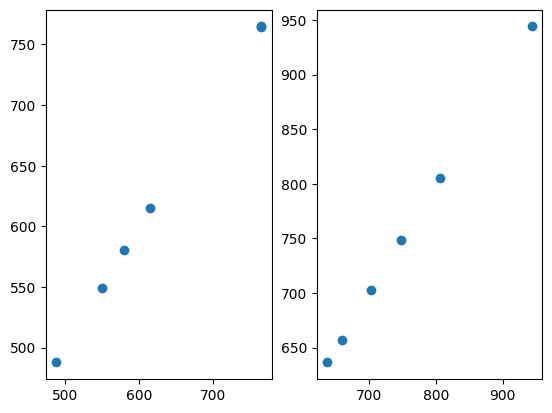

In [15]:
estimated, actual = compute_transformation(no_pairs=no_pairs, M=M1, source=points_1_1, actual=points_1_2)
plt.subplot(1,2,1), plt.scatter(x=actual[0], y=estimated[0])
plt.subplot(1,2,2), plt.scatter(x=actual[1], y=estimated[1])
print(estimated)
print(actual)

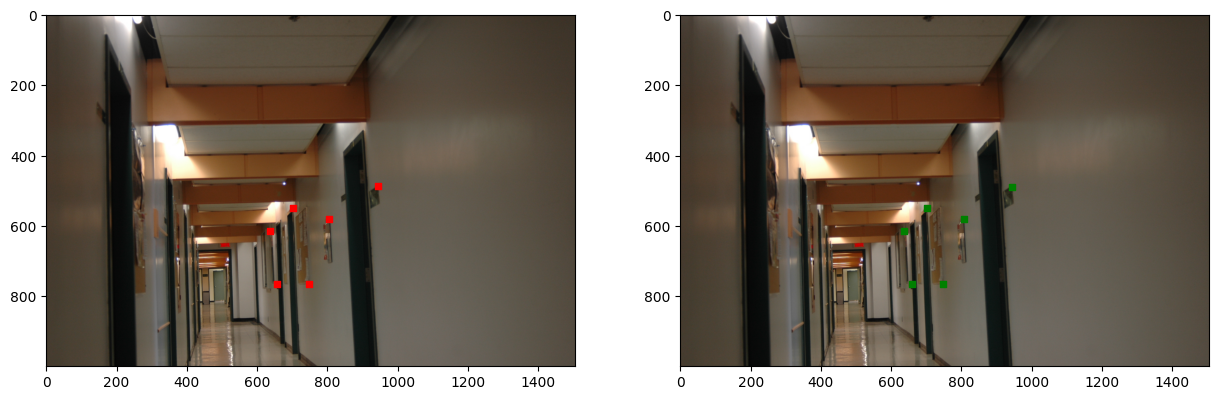

In [16]:
label_est_homography(hallway_2, estimated, actual)

## CASE 2: (right wall 1 ~ 3)

[292 445 227 447 266 180]
[ 774  790  847  883  950 1094]


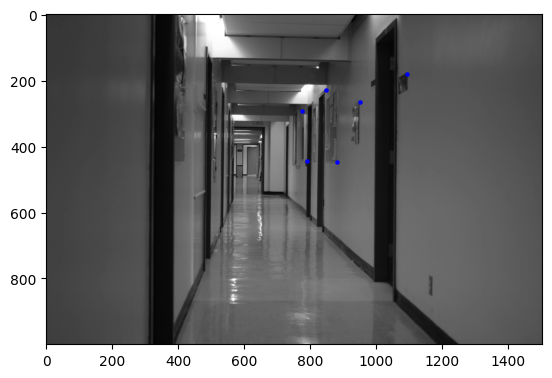

In [17]:
p11 = [292, 774]
p12 = [445, 790]
p13 = [227, 847]
p14 = [447, 883]
p15 = [266, 950]
p16 = [180, 1094]

points_2_1 = [p11, p12, p13, p14, p15, p16]
points_2_1 = np.array(points_2_1)
points_2_1= points_2_1.transpose((1, 0))
print(points_2_1[0])
print(points_2_1[1])
label_points(hallway_1_grey, points_2_1)

[486 636 427 638 445 367]
[781 795 820 846 880 963]


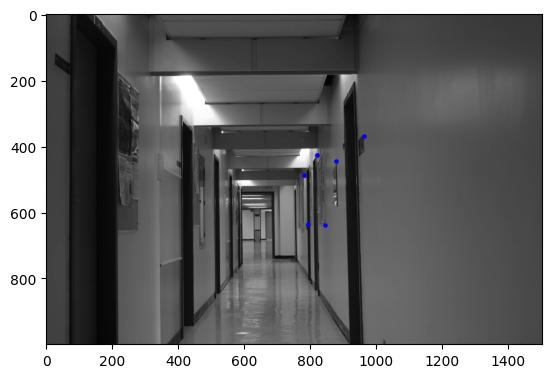

In [18]:
p21 = [486, 781]
p22 = [636, 795]
p23 = [427, 820]
p24 = [638, 846]
p25 = [445, 880]
p26 = [367, 963]

points_2_2 = [p21, p22, p23, p24, p25, p26]
points_2_2 = np.array(points_2_2)
points_2_2= points_2_2.transpose((1, 0))
print(points_2_2[0])
print(points_2_2[1])
label_points(hallway_3_grey, points_2_2)

In [19]:
A2 = find_matrix(pairs=no_pairs, p1=points_2_1, p2=points_2_2)
M2 = compute_homography(A2)
np.savetxt('Q4_prod/Homography_2.csv', M2, delimiter=",")
print(M2)

6
(9, 9)
[[ 1.55896350e-04 -3.05207863e-04  5.54373569e-01]
 [-7.26714129e-04 -4.07554042e-05  8.32266344e-01]
 [-9.04179793e-07 -5.29321149e-07  1.42513363e-03]]


[[483.97049833 632.85966986 429.33194621 640.49296317 448.67917499
  363.72907775]
 [783.21346311 788.41212143 820.1446027  851.62510945 880.42249285
  961.31656362]]
[[486 636 427 638 445 367]
 [781 795 820 846 880 963]]


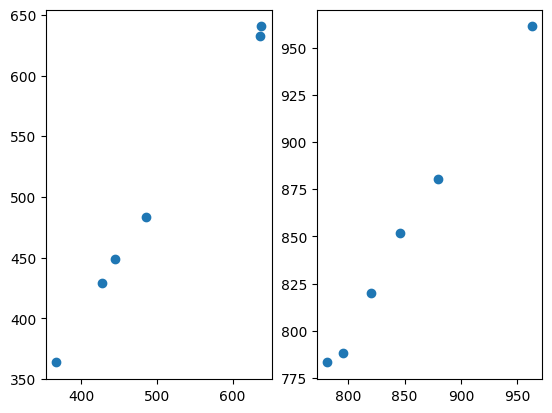

In [20]:
estimated, actual = compute_transformation(no_pairs=no_pairs, M=M2, source=points_2_1, actual=points_2_2)
plt.subplot(1,2,1), plt.scatter(x=actual[0], y=estimated[0])
plt.subplot(1,2,2), plt.scatter(x=actual[1], y=estimated[1])
print(estimated)
print(actual)

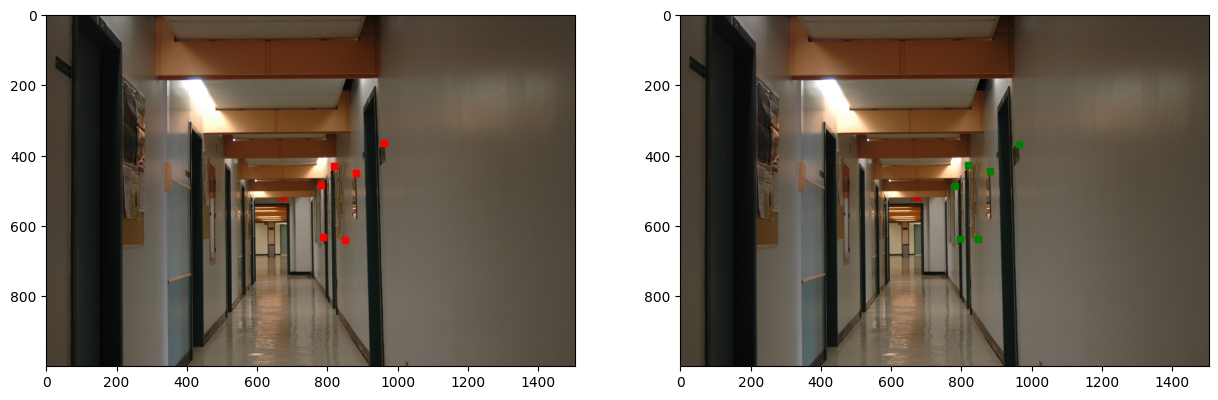

In [21]:
label_est_homography(hallway_3, estimated, actual)

## CASE 3: (floor 1 ~ 3)

[495 546 549 615 744 663]
[599 654 719 790 500 840]


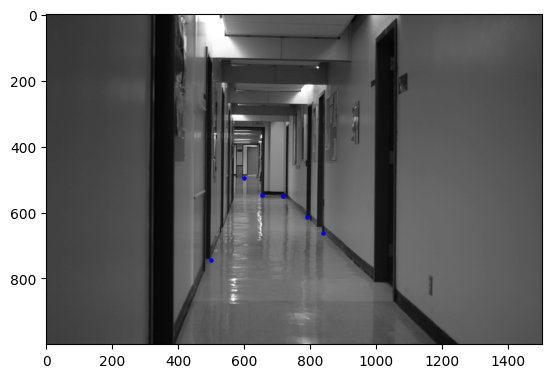

In [22]:
p11 = [495, 599]
p12 = [546, 654]
p13 = [549, 719]
p14 = [615, 790]
p15 = [744, 500]
p16 = [663, 840]

points_3_1 = [p11, p12, p13, p14, p15, p16]
points_3_1 = np.array(points_3_1)
points_3_1= points_3_1.transpose((1, 0))
print(points_3_1[0])
print(points_3_1[1])
label_points(hallway_1_grey, points_3_1)

[689 738 745 812 946 854]
[653 688 753 795 450 827]


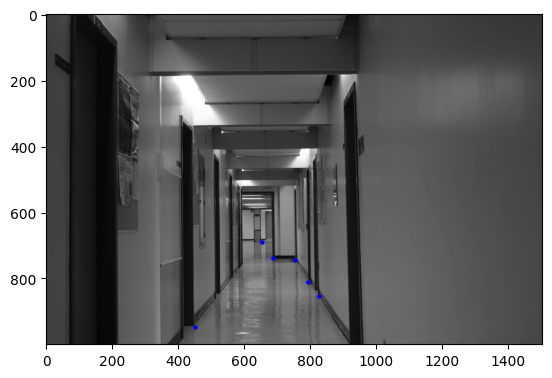

In [23]:
p21 = [689, 653]
p22 = [738, 688]
p23 = [745, 753]
p24 = [812, 795]
p25 = [946, 450]
p26 = [854, 827]

points_3_2 = [p21, p22, p23, p24, p25, p26]
points_3_2 = np.array(points_3_2)
points_3_2= points_3_2.transpose((1, 0))
print(points_3_2[0])
print(points_3_2[1])
label_points(hallway_3_grey, points_3_2)

In [24]:
A3 = find_matrix(pairs=no_pairs, p1=points_3_1, p2=points_3_2)
M3 = compute_homography(A3)
np.savetxt('Q4_prod/Homography_3.csv', M3, delimiter=",")
print(M3)

6
(9, 9)
[[ 9.92886565e-04 -8.06226167e-05  6.72338613e-01]
 [-1.06967131e-03  1.41472248e-03  7.40238187e-01]
 [-6.96226509e-07 -1.03448019e-07  2.01958210e-03]]


[[691.59030121 739.11234461 741.83269554 807.63665333 945.42207216
  858.48009176]
 [656.03208257 688.02316446 748.68400765 794.88500712 449.53407368
  828.91936805]]
[[689 738 745 812 946 854]
 [653 688 753 795 450 827]]


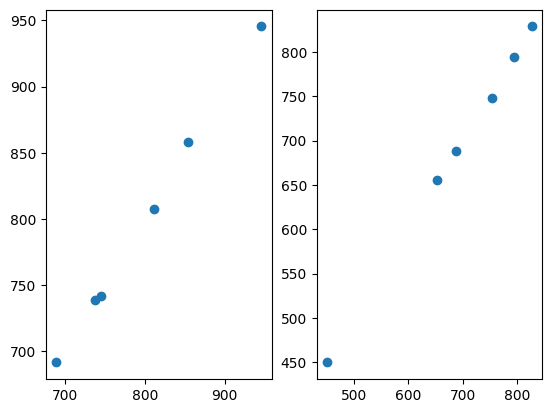

In [25]:
estimated, actual = compute_transformation(no_pairs=no_pairs, M=M3, source=points_3_1, actual=points_3_2)
plt.subplot(1,2,1), plt.scatter(x=actual[0], y=estimated[0])
plt.subplot(1,2,2), plt.scatter(x=actual[1], y=estimated[1])
print(estimated)
print(actual)

## Generate the super-resolution images

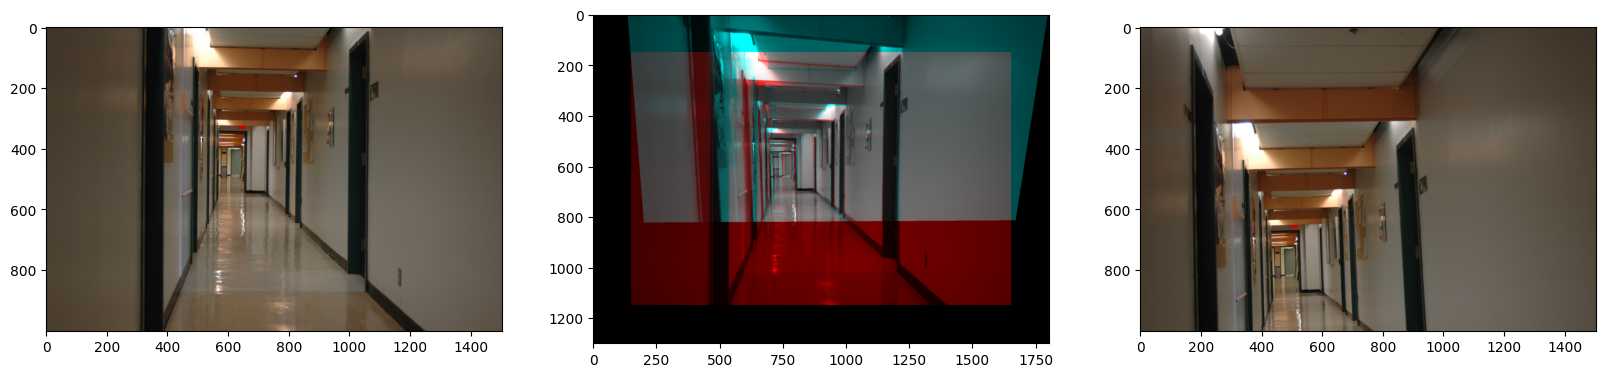

In [26]:
image1 = superesolution(hallway_1_grey, hallway_2_grey, M1)

plt.figure(figsize=(20,6))
plt.subplot(1,3,1), plt.imshow(hallway_1)
plt.subplot(1,3,2), plt.imshow(image1)
plt.subplot(1,3,3), plt.imshow(hallway_2)
plt.savefig('Q4_prod/superres_1.jpg', dpi=400)
plt.show()

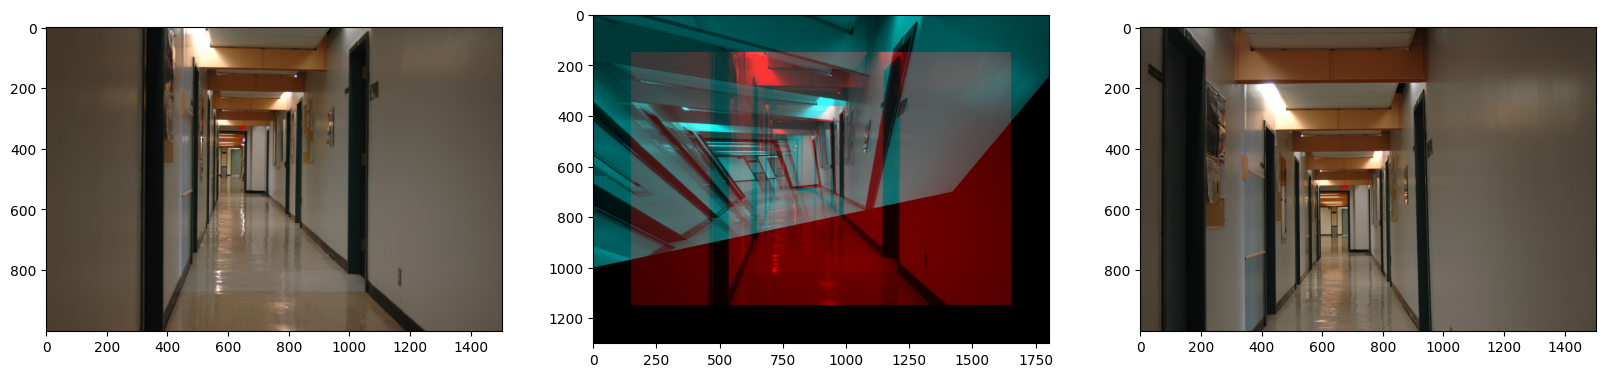

In [27]:
image2 = superesolution(hallway_1_grey, hallway_3_grey, M2)

plt.figure(figsize=(20,6))
plt.subplot(1,3,1), plt.imshow(hallway_1)
plt.subplot(1,3,2), plt.imshow(image2)
plt.subplot(1,3,3), plt.imshow(hallway_3)
plt.savefig('Q4_prod/superres_2.jpg', dpi=400)
plt.show()

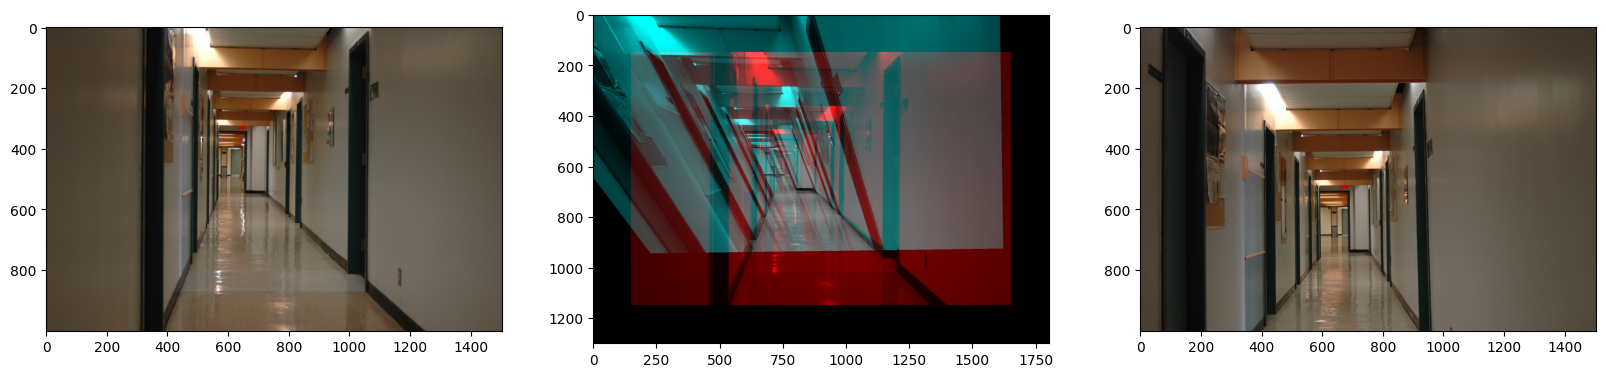

In [28]:
image2 = superesolution(hallway_1_grey, hallway_3_grey, M3)

plt.figure(figsize=(20,6))
plt.subplot(1,3,1), plt.imshow(hallway_1)
plt.subplot(1,3,2), plt.imshow(image2)
plt.subplot(1,3,3), plt.imshow(hallway_3)
plt.savefig('Q4_prod/superres_3.jpg', dpi=400)
plt.show()